# Read in the data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for file in data_files:
    df = pd.read_csv('schools//' + file)
    key_name = file.split('.')[0]
    data[key_name] = df

# Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0,sort=True)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

data['class_size']['padded_csd'] = data['class_size']['CSD'].astype('str').apply(lambda col: col.zfill(2))
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]
pattern= r'\((.+)\)'
data['hs_directory']['lat'] = data['hs_directory']['Location 1'].str.extract(pattern)
data['hs_directory']['lat'] = data['hs_directory']['lat'].str.split(',').str.get(0)
data['hs_directory']['lon'] = data['hs_directory']['Location 1'].str.extract(pattern)
data['hs_directory']['lon'] = data['hs_directory']['lon'].str.split(',').str.get(1)
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size.loc[(class_size['GRADE '] == '09-12') & (class_size['PROGRAM TYPE'] == 'GEN ED')]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data['demographics'] = data['demographics'].loc[data['demographics']['schoolyear'] == 20112012 ]

data['graduation'] = data['graduation'].loc[(data['graduation']['Cohort'] == '2006') & (data['graduation']['Demographic'] == 'Total Cohort')]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined.fillna(combined.mean(),inplace=True)
combined.fillna(0,inplace=True)

# Add a school district column for mapping

In [9]:
combined['school_dist'] = combined['DBN'].str[0:2]

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations.to_string())

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

Text(0.5, 1.0, 'Average school rating by differen groups')

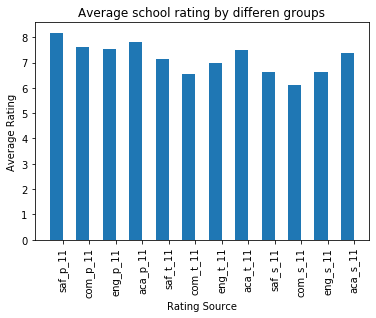

In [12]:
%matplotlib inline

rate_fields = [
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11"
]
bar_heights = combined[rate_fields].mean(axis=0).values
bar_heights
# combined[rate_fields]
bar_positions = np.arange(len(rate_fields)) +0.75
tick_positions = range(1,13)

fig, ax = plt.subplots()

ax.bar(bar_positions,bar_heights,0.5)

ax.set_xticks(tick_positions)
ax.set_xticklabels(rate_fields,rotation=90)
plt.xlabel('Rating Source')
plt.ylabel('Average Rating')
plt.title('Average school rating by differen groups')

Here we have plotted the average ratings based on Parents, Teachers and Students surveys. There are categories like:

- Safety and Respect score
- Comunication score
- Engagement score
- Academic expectations score

In each category of questions pattern is the same. Parents are rating the highest, then teachers and the lowest score is provided by students. 

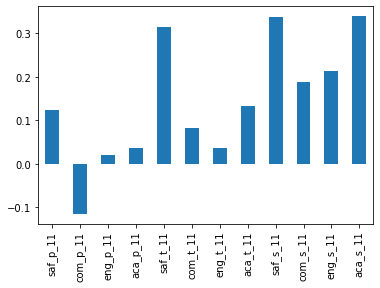

In [57]:
combined.corr().loc['sat_score',rate_fields].plot(kind='bar')

Here we can see that the highest correlation between SAT score and the survey is for students and the lowest for parents. 

Lets dig into relationship between SAT score and safety a bit more.

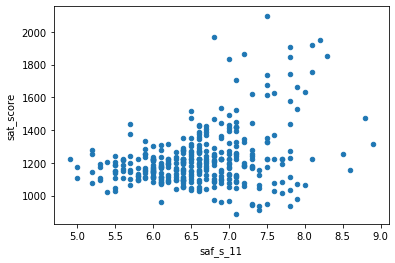

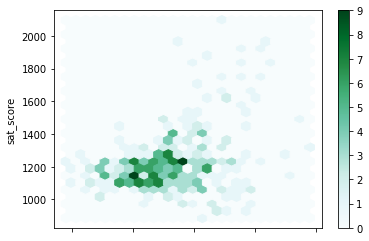

In [17]:
combined.plot(kind='scatter',x='saf_s_11',y='sat_score')

combined.plot(kind='hexbin',x='saf_s_11',y='sat_score',gridsize=25)

Once we plotted both factors we can see that there is a cluster of schools in range between 1050 and 1300 score.

Lets now compute the average safety score for each district.

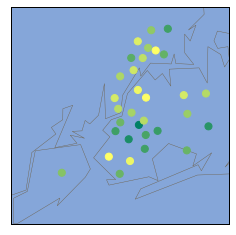

In [26]:
grouped = combined.groupby('school_dist')
safety_dist = grouped.agg(np.mean)
safety_dist.reset_index(inplace=True)

from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i')

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = safety_dist['lon'].tolist()
latitudes = safety_dist['lat'].tolist()

m.scatter(longitudes,latitudes,s=50,zorder=2,latlon=True,c=safety_dist['saf_s_11'],cmap='summer')

High scores for safety are mark as yellow and low score green. We can see that most of low ranked districts in terms of safety are located in Brooklyn. We can compare our findings with NYC Safety maps and see that there is a strong correlation betwen them.

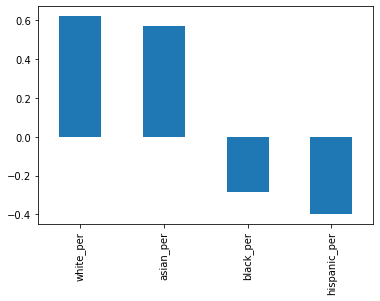

In [33]:
race_columns = ['white_per','asian_per','black_per','hispanic_per']
combined.corr()['sat_score'][race_columns].plot(kind='bar')

We have plotted the correlations between races and SAT scores. As we can see schools with high percentage of white and asian race are more likly to pass at high score, whereas schools where high with high percentage of black and hispanic are more likly to get a low score.

Lets now explore schools with low SAP scores and high percentage of hispanic race.

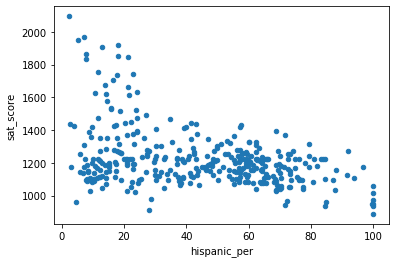

In [35]:
combined.plot.scatter(x='hispanic_per',y='sat_score')

Our scatter plot shows thats if the percentage of hispanic corses 25% the SAT score is less then 1500 points. For 100% hispanic schools the SAT score is less then 1200 points.

Lets now check schools woth a hispanic_per close to 100%

In [38]:
combined.loc[combined['hispanic_per']>95,['SCHOOL NAME','sat_score','ell_percent']]

,SCHOOL NAME,sat_score,ell_percent
44,MANHATTAN BRIDGES HIGH SCHOOL,1058.0,72.6
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,1174.0,19.6
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,1014.0,89.6
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,951.0,86.6
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,934.0,79.9
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,970.0,92.9
253,MULTICULTURAL HIGH SCHOOL,887.0,94.6
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,951.0,91.3


All of these schools have low SAT score and high percentage of english learners.

In [39]:
combined.loc[(combined['hispanic_per']<10) & (combined['sat_score']>1800),['SCHOOL NAME','sat_score','ell_percent']]

,SCHOOL NAME,sat_score,ell_percent
37,STUYVESANT HIGH SCHOOL,2096.0,0.0
151,BRONX HIGH SCHOOL OF SCIENCE,1969.0,0.1
187,BROOKLYN TECHNICAL HIGH SCHOOL,1833.0,0.1
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,1868.0,0.2
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,1953.0,0.1


Schools with high score and hispanic race less then 10% have students who are native english speakers. Majority of students are Asian.

Lets now compare gender along SAT score.

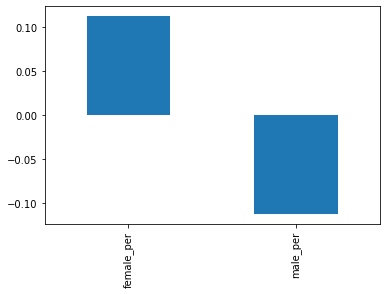

In [41]:
combined.corr()['sat_score'][['female_per','male_per']].plot(kind='bar')

There is a weak correlation between gender and SAT score. Women are more likly to get a higher score.

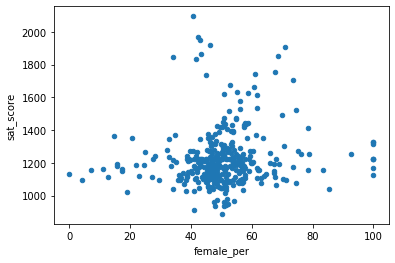

In [43]:
combined.plot(kind='scatter',x='female_per',y='sat_score')

Graph shows that schools with less then 35% of female are scoring no more then 1400 points. While for schools with less then 35% of men thats not the case.

In [47]:
combined.loc[(combined['female_per']>60) & (combined['sat_score']>1700),['SCHOOL NAME','sat_score','ell_percent','female_per']]

,SCHOOL NAME,sat_score,ell_percent,female_per
5,BARD HIGH SCHOOL EARLY COLLEGE,1856.0,0.2,68.7
26,ELEANOR ROOSEVELT HIGH SCHOOL,1758.0,0.2,67.5
60,BEACON HIGH SCHOOL,1744.0,0.2,61.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,1707.0,0.2,73.6
302,TOWNSEND HARRIS HIGH SCHOOL,1910.0,0.0,71.1


All of these have hiht rate of white and asian students and low percentage of english learners.

In [48]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

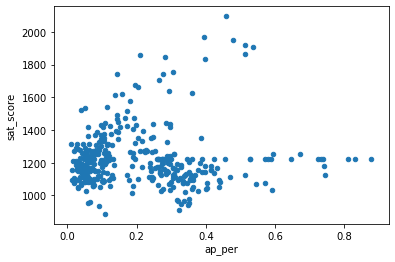

In [50]:
combined.plot(kind='scatter',x='ap_per',y='sat_score')

Graph shows that schools witch above 60% of AP exam taker are scoring less then 1300 points on SAT exam. The best SAT score get schools with AP participation between 20 and 60%.

Lets check the correlation between class size and SAT score.

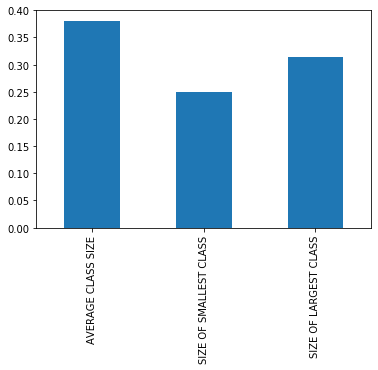

In [53]:
combined.corr()['sat_score'][['AVERAGE CLASS SIZE','SIZE OF SMALLEST CLASS','SIZE OF LARGEST CLASS']].plot(kind='bar')

We could have expected that there would be a negative correlation between class size and SAT score. Thinking that if smaller class is then teacher can put more attention to individuals. But our results show opposite. Let's plot that to see whethere how does it look on the graph.

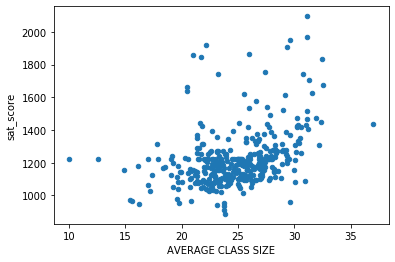

In [55]:
combined.plot(kind='scatter',x='AVERAGE CLASS SIZE',y='sat_score')

Indeed there is a correlation for classes of size 20 and less the SAT score is less then 1400 points.There may be a number of reasons for that. One of them could be that low ranked schools get less interest of students so more students go to better ranked schools which means that classes are larger it that schools.

In [202]:
combined_updated = combined.copy()

In [203]:
property_value = pd.read_csv('schools\\property_income.csv')
property_value

,Borough,Block,Lot,Address,ZIP Code,Final 18/19 Actual AV,Tax Class,Bldg. Class,RPIE Year,Status,X Coordinate,Y Coordinate,Latitude,Longitude,Community District,City Council District,Census Tract,BIN,BBL,NTA
0,Manhattan,8,39,32 PEARL STREET,10004,5982300,4,H3,2017,Nonfiler,980806.0,195484.0,40.703235,-74.012421,101.0,1.0,9.0,1078968.0,1.000080e+09,Battery Park City-Lower Manhattan
1,Manhattan,17,1205,50 WEST STREET #COMM2,10006,67511,4,RB,2017,Nonfiler,979940.0,197211.0,40.707975,-74.015546,101.0,1.0,13.0,1000000.0,1.000178e+09,Battery Park City-Lower Manhattan
2,Manhattan,17,1207,50 WEST STREET #COMM4,10006,76370,4,RB,2017,Nonfiler,979940.0,197211.0,40.707975,-74.015546,101.0,1.0,13.0,1000000.0,1.000178e+09,Battery Park City-Lower Manhattan
3,Manhattan,17,1210,50 WEST STREET #COMM7,10006,92295,4,RB,2017,Nonfiler,979940.0,197211.0,40.707975,-74.015546,101.0,1.0,13.0,1000000.0,1.000178e+09,Battery Park City-Lower Manhattan
4,Manhattan,17,1213,50 WEST STREET #COMM1,10006,68856,4,RB,2017,Nonfiler,979940.0,197211.0,40.707975,-74.015546,101.0,1.0,13.0,1000000.0,1.000178e+09,Battery Park City-Lower Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,Staten Island,8047,1,7481 AMBOY ROAD,10307,4,K4,"$98,100",2017,Nonfiler,916018.0,125001.0,40.509512,-74.245375,503.0,5.0,248.0,5104962.0,5.080470e+09,Charleston-Richmond Valley-Tottenville
15343,Staten Island,8047,21,249 MAIN STREET,10307,4,K2,"$113,850",2017,Nonfiler,915572.0,124868.0,40.509143,-74.246977,503.0,5.0,248.0,5089265.0,5.080470e+09,Charleston-Richmond Valley-Tottenville
15344,Staten Island,8047,22,245 MAIN STREET,10307,4,K1,"$91,350",2017,Nonfiler,915550.0,124900.0,40.509231,-74.247057,503.0,5.0,248.0,5089266.0,5.080470e+09,Charleston-Richmond Valley-Tottenville
15345,Staten Island,8047,28,231 MAIN STREET,10307,4,K4,"$166,050",2017,Nonfiler,915472.0,125013.0,40.509541,-74.247338,503.0,5.0,248.0,5104961.0,5.080470e+09,Charleston-Richmond Valley-Tottenville


We are interested in actual value column but we can see that there is something wrong with values it looks like in the tail part columns are switched. We need to switch the second part of column 7 with column 4.

In [204]:
property_value.loc[property_value['Final 18/19 Actual AV']<5]

,Borough,Block,Lot,Address,ZIP Code,Final 18/19 Actual AV,Tax Class,Bldg. Class,RPIE Year,Status,X Coordinate,Y Coordinate,Latitude,Longitude,Community District,City Council District,Census Tract,BIN,BBL,NTA
1514,Staten Island,766,15,BRADLEY AVENUE,10314,4,G7,"$62,100",2017,Nonfiler,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1605,Staten Island,4624,373,AMBOY ROAD,10308,4,G7,"$84,600",2017,Nonfiler,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14454,Staten Island,1,10,139 BAY STREET,10301,4,E1,"$670,950",2017,Nonfiler,963233.0,172008.0,40.638774,-74.075727,501.0,5.0,3.0,5000001.0,5.000010e+09,West New Brighton-New Brighton-St. George
14455,Staten Island,1,1402,35R BAY STREET # RES,10301,4,RH,"$487,317",2017,Nonfiler,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14456,Staten Island,2,759,7 BANK STREET,10301,4,E1,"$143,550",2017,Nonfiler,959562.0,175084.0,40.647208,-74.088966,501.0,5.0,7.0,5127496.0,5.000021e+09,West New Brighton-New Brighton-St. George
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,Staten Island,8047,1,7481 AMBOY ROAD,10307,4,K4,"$98,100",2017,Nonfiler,916018.0,125001.0,40.509512,-74.245375,503.0,5.0,248.0,5104962.0,5.080470e+09,Charleston-Richmond Valley-Tottenville
15343,Staten Island,8047,21,249 MAIN STREET,10307,4,K2,"$113,850",2017,Nonfiler,915572.0,124868.0,40.509143,-74.246977,503.0,5.0,248.0,5089265.0,5.080470e+09,Charleston-Richmond Valley-Tottenville
15344,Staten Island,8047,22,245 MAIN STREET,10307,4,K1,"$91,350",2017,Nonfiler,915550.0,124900.0,40.509231,-74.247057,503.0,5.0,248.0,5089266.0,5.080470e+09,Charleston-Richmond Valley-Tottenville
15345,Staten Island,8047,28,231 MAIN STREET,10307,4,K4,"$166,050",2017,Nonfiler,915472.0,125013.0,40.509541,-74.247338,503.0,5.0,248.0,5104961.0,5.080470e+09,Charleston-Richmond Valley-Tottenville


In [205]:
property_value.loc[property_value['Bldg. Class'].str.contains(',')]

,Borough,Block,Lot,Address,ZIP Code,Final 18/19 Actual AV,Tax Class,Bldg. Class,RPIE Year,Status,X Coordinate,Y Coordinate,Latitude,Longitude,Community District,City Council District,Census Tract,BIN,BBL,NTA
1514,Staten Island,766,15,BRADLEY AVENUE,10314,4,G7,"$62,100",2017,Nonfiler,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1605,Staten Island,4624,373,AMBOY ROAD,10308,4,G7,"$84,600",2017,Nonfiler,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14454,Staten Island,1,10,139 BAY STREET,10301,4,E1,"$670,950",2017,Nonfiler,963233.0,172008.0,40.638774,-74.075727,501.0,5.0,3.0,5000001.0,5.000010e+09,West New Brighton-New Brighton-St. George
14455,Staten Island,1,1402,35R BAY STREET # RES,10301,4,RH,"$487,317",2017,Nonfiler,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14456,Staten Island,2,759,7 BANK STREET,10301,4,E1,"$143,550",2017,Nonfiler,959562.0,175084.0,40.647208,-74.088966,501.0,5.0,7.0,5127496.0,5.000021e+09,West New Brighton-New Brighton-St. George
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,Staten Island,8047,1,7481 AMBOY ROAD,10307,4,K4,"$98,100",2017,Nonfiler,916018.0,125001.0,40.509512,-74.245375,503.0,5.0,248.0,5104962.0,5.080470e+09,Charleston-Richmond Valley-Tottenville
15343,Staten Island,8047,21,249 MAIN STREET,10307,4,K2,"$113,850",2017,Nonfiler,915572.0,124868.0,40.509143,-74.246977,503.0,5.0,248.0,5089265.0,5.080470e+09,Charleston-Richmond Valley-Tottenville
15344,Staten Island,8047,22,245 MAIN STREET,10307,4,K1,"$91,350",2017,Nonfiler,915550.0,124900.0,40.509231,-74.247057,503.0,5.0,248.0,5089266.0,5.080470e+09,Charleston-Richmond Valley-Tottenville
15345,Staten Island,8047,28,231 MAIN STREET,10307,4,K4,"$166,050",2017,Nonfiler,915472.0,125013.0,40.509541,-74.247338,503.0,5.0,248.0,5104961.0,5.080470e+09,Charleston-Richmond Valley-Tottenville


In [206]:
property_value['prop_value'] = property_value['Final 18/19 Actual AV']
property_value['prop_value'] = property_value['prop_value'].mask(property_value['Final 18/19 Actual AV']<5,property_value['Bldg. Class'])
property_value['prop_value'] = property_value['prop_value'].astype('str').str.replace('$','').str.replace(',','').astype('int')
prop_valid = property_value[['ZIP Code','prop_value']]
prop_valid.rename({'ZIP Code':'zip'},axis=1,errors='raise',inplace=True)
prop_valid

,zip,prop_value
0,10004,5982300
1,10006,67511
2,10006,76370
3,10006,92295
4,10006,68856
...,...,...
15342,10307,98100
15343,10307,113850
15344,10307,91350
15345,10307,166050


In [207]:
grouped_values = prop_valid.groupby('zip')
values_byzip = grouped_values.agg(np.mean)
values_byzip.reset_index(inplace=True)

In [208]:
combined_updated_new=combined_updated.merge(values_byzip,on='zip',how='left')
combined_updated_new['prop_value'].isnull().sum()

1

There is only one NaN so lets find it and replace by average value of the same borough.

In [209]:
combined_updated_new.loc[combined_updated_new['prop_value'].isnull(),:] 

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,ap_per,prop_value
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,1510.0,2819.0,...,0,0,0,0,"345 Chambers Street\r\nNew York, NY 10282\r\n(...",40.717746,-74.014049,02,0.457992,NaN


In [210]:
grouped_values = property_value.groupby('Borough')
values_bybor = grouped_values.agg(np.mean)
values_bybor.reset_index(inplace=True)

combined_updated_new.loc[combined_updated_new['prop_value'].isnull(),'prop_value'] = values_bybor.loc[values_bybin['Borough']==combined_updated_new.iloc[37]['boro'],'prop_value']

We have replaced that missing value with the average value of that borough.

In [214]:
combined_updated_new.corr()['sat_score']['prop_value']

0.16464132524407274

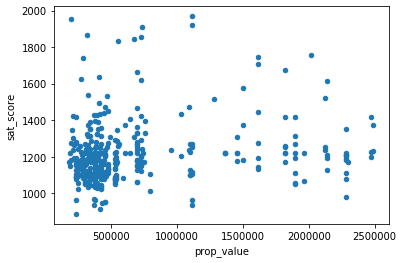

In [215]:
combined_updated_new.plot(kind='scatter',x='prop_value',y='sat_score')

It shows that there is no strong correlation between property costs in the area and how students pass their SAT test.